## 基于timestamp的事件重构b-重离子和衰变事件的关联
数据：sort.root (按照上一次课件的描述生成root文件）

TTree Branch: 
- timestamp, xstrip, ystrip, de //de- dssd front energy
- me //mwpc energy, me<0 when no dssd signal

### alpha sepctrum:
![](alpha.png)

In [1]:
TCanvas *c1=new TCanvas("c1","c1");
TFile *fin=new TFile("sort1.root");
TTree *tree=(TTree*)fin->Get("tree");
tree->Print();
ULong64_t timestamp;
Int_t xstrip,ystrip;
Float_t me,de;
tree->SetBranchAddress("timestamp",&timestamp);
tree->SetBranchAddress("xstrip",&xstrip);
tree->SetBranchAddress("ystrip",&ystrip);
tree->SetBranchAddress("de",&de);
tree->SetBranchAddress("me",&me);

******************************************************************************
*Tree    :tree      : sorted events                                          *
*Entries :   107132 : Total =         2580778 bytes  File  Size =    1816238 *
*        :          : Tree compression factor =   1.42                       *
******************************************************************************
*Br    0 :timestamp : timestamp/l                                            *
*Entries :   107132 : Total  Size=     859977 bytes  File Size  =     696371 *
*Baskets :       27 : Basket Size=      32000 bytes  Compression=   1.23     *
*............................................................................*
*Br    1 :me        : me/F                                                   *
*Entries :   107132 : Total  Size=     430067 bytes  File Size  =     298254 *
*Baskets :       14 : Basket Size=      32000 bytes  Compression=   1.44     *
*...................................................

In [2]:
//tree->Scan("xstrip:ystrip:timestamp:me","","colsize=30",100,10000);

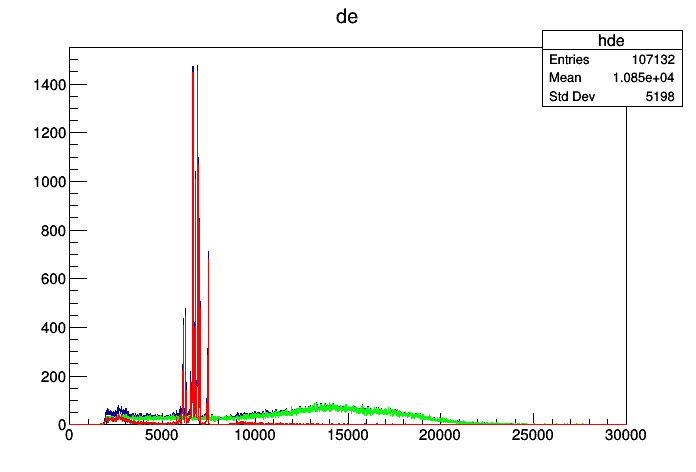

4171


In [3]:
tree->Draw("de>>hde(3000,0,30000)");//all
tree->Draw("de>>hdem(3000,0,30000)","me>0");//coincide with mwpc
tree->Draw("de>>hdenm(3000,0,30000)","me<0");//mwpc veto
TH1F *hde, *hdem, *hdenm;
hde=(TH1F*)gROOT->FindObject("hde");
hdem=(TH1F*)gROOT->FindObject("hdem");
hdenm=(TH1F*)gROOT->FindObject("hdenm");
hde->Draw();
hdem->SetLineColor(kGreen);
hdenm->SetLineColor(kRed);
hdem->Draw("same");
hdenm->Draw("same");
c1->Draw();
cout<<hdem->Integral(600,750)<<endl;

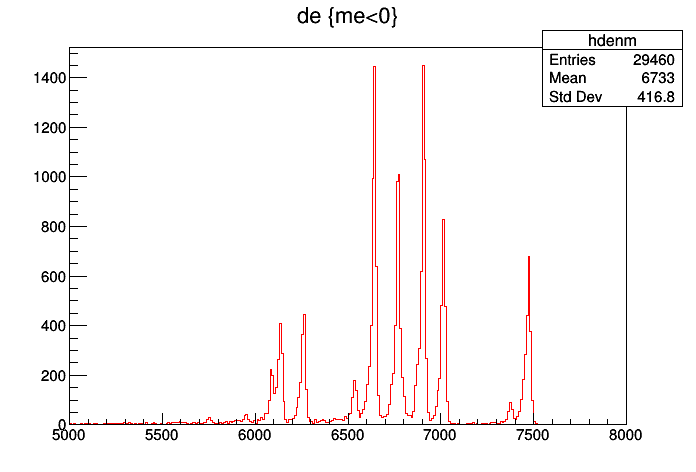

In [4]:
hdenm->GetXaxis()->SetRangeUser(5000,8000);
hdenm->Draw();
c1->Draw();

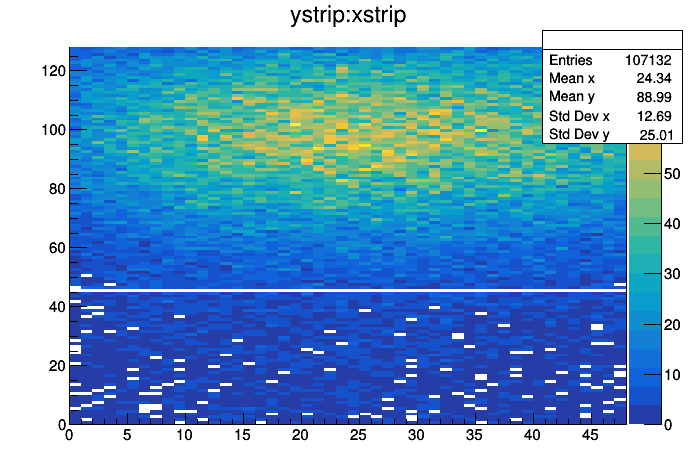

In [5]:
tree->Draw("ystrip:xstrip>>(48,0,48,128,0,128)","","colz");
c1->SetLogy(0);
c1->SetLogz(0);
c1->Draw();

## 按照mwpc上的能量对事件进行分类
- 重离子(Implantation) me>0
- 衰变粒子(Decay) me<0

In [6]:
struct dssd
{
    Float_t energy;
    Int_t xstrip,ystrip;
};
dssd ds;
multimap<ULong64_t, dssd> mapimp, mapdec;//implantaion, decay

Long64_t nentries = tree->GetEntriesFast();
for (Long64_t jentry=0; jentry<nentries;jentry++) {
    tree->GetEntry(jentry);
        ds.energy = de;
        ds.xstrip = xstrip;
        ds.ystrip = ystrip;
    if(me>0) mapimp.insert(pair<ULong64_t,dssd>(timestamp,ds));
    else mapdec.insert(pair<ULong64_t,dssd>(timestamp,ds));
}
cout<<"The number of implantation/decay : "<<mapimp.size()<<"  "<<mapdec.size()<<endl;

The number of implantation/decay : 77672  29460


## 重离子与衰变事件的关联
- 由于束流在DSSD上有着很宽的位置分布(通过调束，使得束流在注入探测器上有着较宽的分布)，且DSSD的每个pixel面积很小，可以认为在重离子强度不高时，重离子注入到某一颗粒后在一段不长的时间范围内，该颗粒上发生的衰变事件都是由该重离子的衰变产生的。换句话说，可将DSSD探测器看成由 $x \times y$ 个独立的探测单元，每个单元在一段时间内只有一个重离子($t=t_0$)注入，并发生衰变($t=t_d$)（图.a）。此时衰变和注入事件之间的时间差$\delta t=t_d-t_0$，服从指数衰减分布，衰减常数由重离子的半衰期决定。当该单元上发生的衰变事件($t=t_d'$)不是来源于上一个重离子衰变，而是由其他时间内注入的其他重离子($t<t_0$)的衰变引起 (图.b)，那么这些事件的衰变-重离子之间不存在上述关联，其时间差 $t_d'-t_0$在时间轴上均匀分布。上述将不同时刻发生的重离子和衰变事件关联起来的方法称为position-time correlation for implantation and decay events。
![](correlation.png)


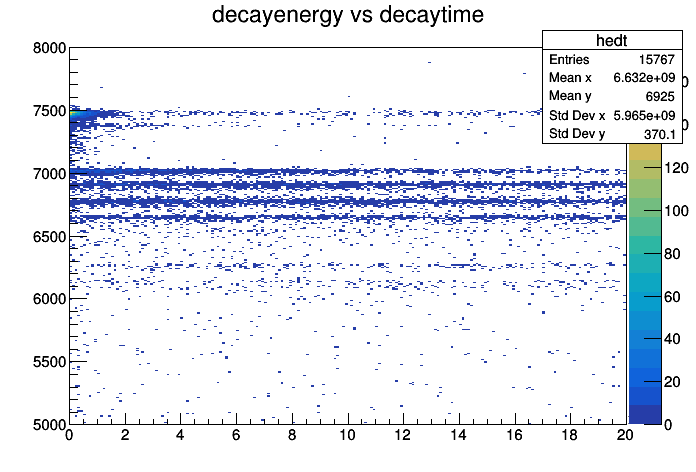

In [7]:
ULong64_t twindow = 20000000000;//20s
TH2F *hedt=new TH2F("hedt","decayenergy vs decaytime",200,0,2e10,300,5000,8000);

for(auto ia=mapimp.begin(); ia!=mapimp.end();ia++) {
     auto ib=mapdec.lower_bound(ia->first);
     for(auto ic=ib; ic!=mapdec.end();ic++) {
        if(ic->first >= ia->first + twindow) break;
        if(abs(ic->second.xstrip-ia->second.xstrip)>0) continue;
        if(abs(ic->second.ystrip-ia->second.ystrip)>0) continue;
        Long64_t decaytime = (ic->first - ia->first);
        hedt->Fill(decaytime,ic->second.energy);
    }   
}
hedt->Draw("colz");
c1->Draw();

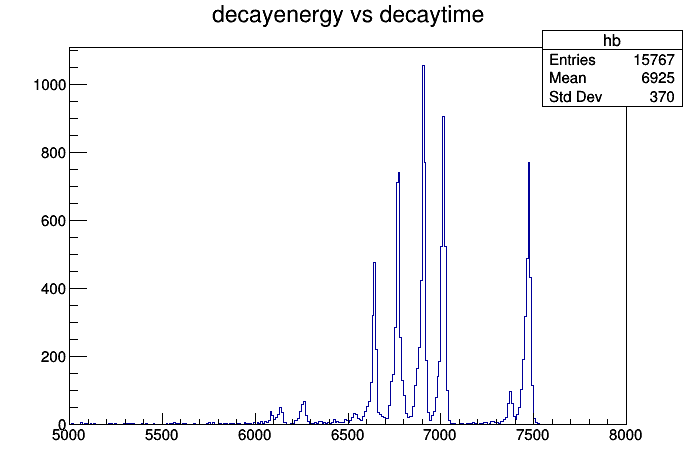

In [8]:
TH1F *hb=(TH1F*)hedt->ProjectionY("hb");
hb->Draw();
c1->Draw();

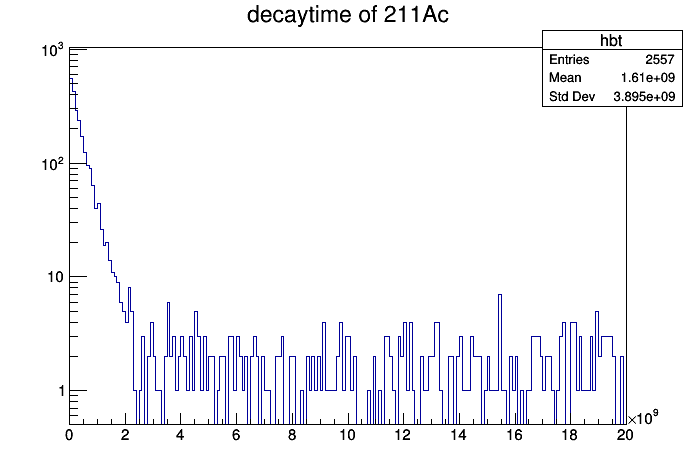

In [9]:
hedt->GetYaxis()->SetRangeUser(7400,7600);
TH1F *hbt=(TH1F*)hedt->ProjectionX("hbt");
hbt->SetTitle("decaytime of 211Ac");
hbt->Draw();
c1->SetLogy();
c1->Draw();

## 从上图可见，衰变曲线中有其他不关联事件形成的均匀分布的本底平台。


## 减本底的方法
可选用两种方法之一
- 1. 大于5个半衰期之后的平台本底
- 2. 生成负时间本底

## 减去5个半衰期以后的平台本底

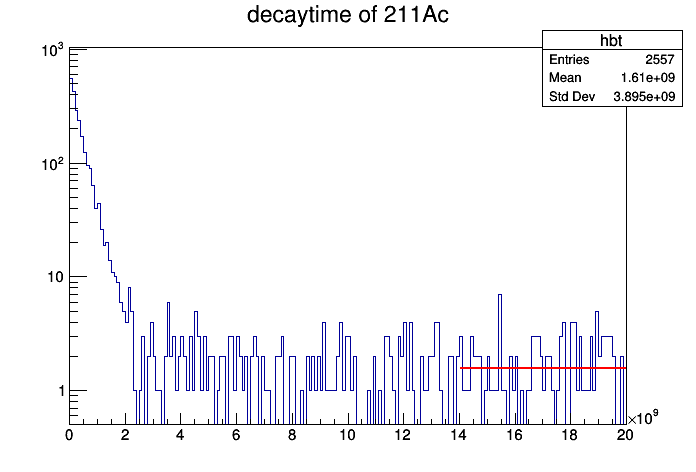


****************************************
Minimizer is Linear
Chi2                      =       27.101
NDf                       =           49
p0                        =      1.55798   +/-   0.176521    


In [10]:
TF1 *fp01= new TF1("fp01","pol0",1.5e10,2e10);
hbt->Fit(fp01,"R");
Double_t p01=fp01->GetParameter(0);
c1->SetLogy();
c1->Draw();

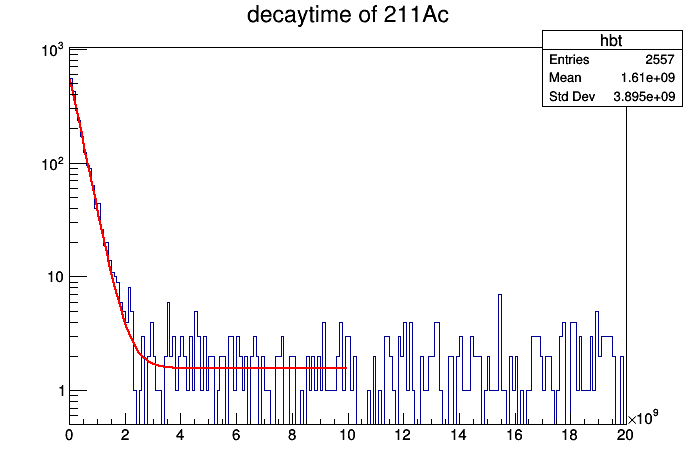

 FCN=46.162 FROM MIGRAD    STATUS=CONVERGED     101 CALLS         102 TOTAL
                     EDM=4.47646e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.55798e+00     fixed    
   2  p1           6.14301e+02   1.96923e+01  -4.14304e-02  -1.39429e-05
   3  p2           2.50602e+08   6.11076e+06   3.03412e+04  -9.48712e-11

half-life of 211Ac is 250.602 +/- 6.11076 ms


In [11]:
TF1 *fdecay1= new TF1("fdecay1","[0]+[1]*TMath::Exp(-x*TMath::Log(2.)/[2])",1,1e10);
fdecay1->FixParameter(0,p01);
fdecay1->SetParameter(2,1e8);
hbt->Fit(fdecay1,"R");
cout<<endl;
cout<<"half-life of 211Ac is "<<fdecay1->GetParameter(2)/1e6<<" +/- "<<fdecay1->GetParError(2)/1e6<<" ms"<<endl;
c1->SetLogy();
c1->Draw();

## 减负时间本底

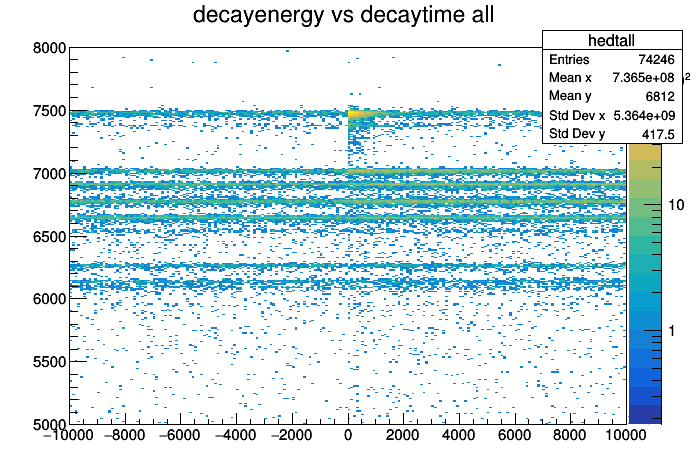

In [12]:
twindow = 20000000000;//20s
TH2F *hedtall=new TH2F("hedtall","decayenergy vs decaytime all ",200,-1e10,1e10,300,5000,8000);
TH2F *hedtpos=new TH2F("hedtpos","decayenergy vs decaytime positive time",200,0,1e10,300,5000,8000);
TH2F *hedtneg=new TH2F("hedtneg","decayenergy vs decaytime negative time",200,0,1e10,300,5000,8000);
TH2F *hedtsub=new TH2F("hedtsub","decayenergy vs decaytime negative time",200,0,1e10,300,5000,8000);
for(auto ia=mapimp.begin(); ia!=mapimp.end();ia++) {
     auto ib=mapdec.lower_bound(ia->first-twindow);
     for(auto ic=ib; ic!=mapdec.end();ic++) {
        if(ic->first >= ia->first + twindow) break;
        if(abs(ic->second.xstrip-ia->second.xstrip)>1) continue;
        if(abs(ic->second.ystrip-ia->second.ystrip)>1) continue;
        Long64_t decaytime = ic->first - ia->first;
        hedtall->Fill(decaytime,ic->second.energy);
        if(decaytime>0) hedtpos->Fill(decaytime,ic->second.energy);
        else hedtneg->Fill(-decaytime,ic->second.energy);
    }   
}
hedtall->Draw("colz");
c1->SetLogy(0);
c1->SetLogz();
c1->Draw();

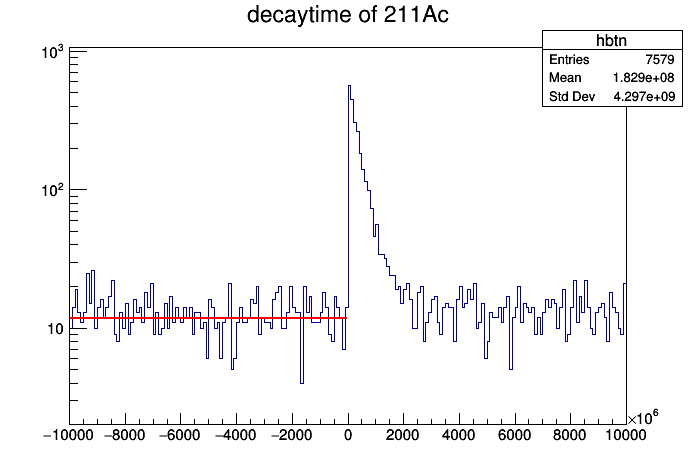


****************************************
Minimizer is Linear
Chi2                      =      129.286
NDf                       =           99
p0                        =      11.7171   +/-   0.342303    


In [13]:
hedtall->GetYaxis()->SetRangeUser(7400,7600);
TH1F *hbtn=(TH1F*)hedtall->ProjectionX("hbtn");
hbtn->SetTitle("decaytime of 211Ac");
TF1 *fp0= new TF1("fp0","pol0",-1e10,0);
hbtn->Fit(fp0,"R");
Double_t p0=fp0->GetParameter(0);
c1->SetLogy();
c1->Draw();

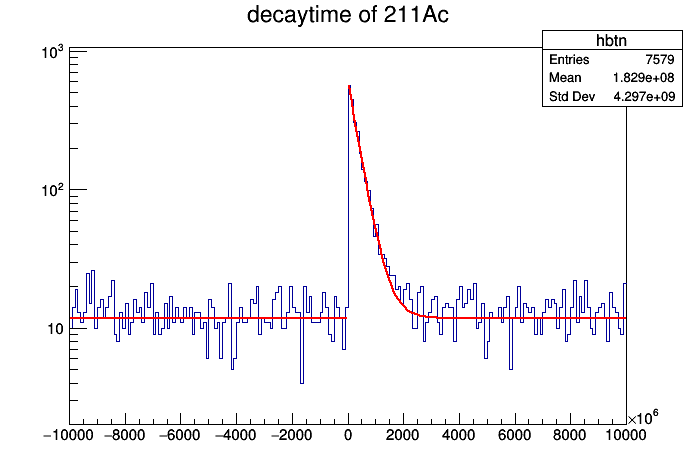

 FCN=109.05 FROM MIGRAD    STATUS=CONVERGED     102 CALLS         103 TOTAL
                     EDM=7.32812e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   4.1 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.17171e+01     fixed    
   2  p1           6.22599e+02   2.08343e+01  -1.58079e-01  -3.60187e-06
   3  p2           2.53971e+08   7.09112e+06   1.09898e+05  -6.10852e-12

half-life of 211Ac is 253.971 +/- 7.09112 ms


In [14]:
TF1 *fdecay= new TF1("fdecay","[0]+[1]*TMath::Exp(-x*TMath::Log(2.)/[2])",1,1e10);
fdecay->FixParameter(0,p0);
fdecay->SetParameter(2,1e8);
hbtn->Fit(fdecay,"R");
fp0->Draw("same");
cout<<endl;
cout<<"half-life of 211Ac is "<<fdecay->GetParameter(2)/1e6<<" +/- "<<fdecay->GetParError(2)/1e6<<" ms"<<endl;
c1->SetLogy();
c1->Draw();

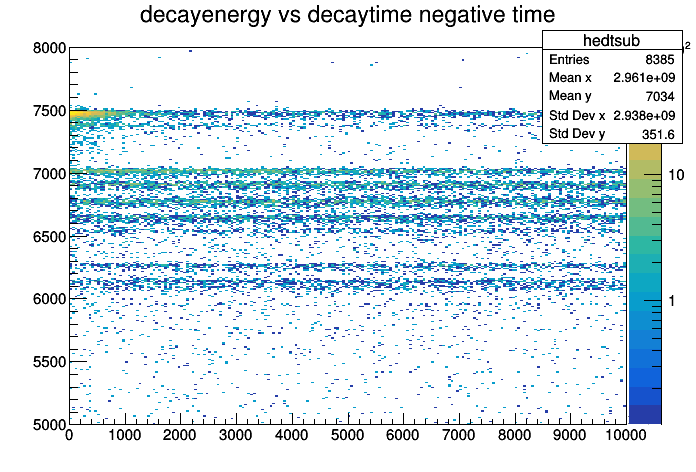

In [15]:
hedtsub->Add(hedtpos,hedtneg,1,-1);
hedtsub->Draw("colz");
c1->SetLogy(0);
c1->Draw();

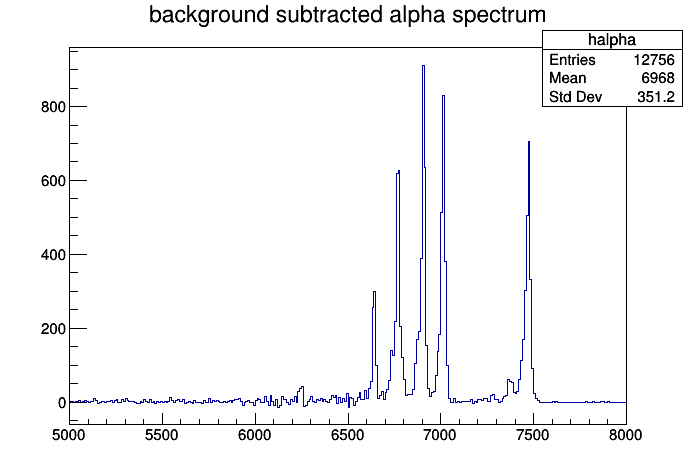

In [16]:
TH1F *halpha=(TH1F*)hedtsub->ProjectionY("halpha");
halpha->SetTitle("background subtracted alpha spectrum");
halpha->Draw();
c1->SetLogy(0);
c1->Draw();

#### 对比前后三幅alpha能谱中7450keV(211Ac) 峰的计数，减完本底后的峰计数与原先的峰的计数类似。